### Imports

In [1]:
import pandas as pd
import numpy as np
import datetime
import uuid
import matplotlib.pyplot as plt
import matplotlib
import descartes
import geopandas as gpd
from shapely.geometry import Point, Polygon
from shapely.geometry.polygon import Polygon as Polygon2
# import contextily as ctx
from sklearn.cluster import KMeans
import folium
from glob import glob

### Helper Functions

In [2]:
def get_one_day(df, date):
    return df[df['Date'] == date].copy()

def compute_haverstine(df, lat1, long1, lat2, long2):
    # Compute distance between two points
    # https://stackoverflow.com/questions/25767596/vectorised-haversine-formula-with-a-pandas-dataframe
    df['lat_rad'], df['lng_rad'] = np.radians(df[lat1]), np.radians(df[long1])
    
    df['dLON'] = df['lng_rad'] - np.radians(df[long2])
    df['dLAT'] = df['lat_rad'] - np.radians(df[lat2])
    df['distance_km'] = 6367 * 2 * np.arcsin(np.sqrt(np.sin(df['dLAT']/2)**2 +\
                                                  np.cos(np.radians(df[lat2])) * 
                                                  np.cos(df['lat_rad']) * 
                                                  np.sin(df['dLON']/2)**2))
    
    df['distance_miles'] = df['distance_km'] * 0.621371
    df.drop(['dLON', 'dLAT', 'distance_km', 'lat_rad', 'lng_rad'], axis=1, inplace = True)
    return df.copy()

def get_bearing(p1, p2):
    # credit: https://medium.com/@bobhaffner/folium-lines-with-arrows-25a0fe88e4e
    '''
    Returns compass bearing from p1 to p2
    
    Parameters
    p1 : namedtuple with lat lon
    p2 : namedtuple with lat lon
    
    Return
    compass bearing of type float
    
    Notes
    Based on https://gist.github.com/jeromer/2005586
    '''
    
    long_diff = np.radians(p2.lon - p1.lon)
    
    lat1 = np.radians(p1.lat)
    lat2 = np.radians(p2.lat)
    
    x = np.sin(long_diff) * np.cos(lat2)
    y = (np.cos(lat1) * np.sin(lat2) 
        - (np.sin(lat1) * np.cos(lat2) 
        * np.cos(long_diff)))
    bearing = np.degrees(np.arctan2(x, y))
    
    # adjusting for compass bearing
    if bearing < 0:
        return bearing + 360
    return bearing

def get_arrows(locations, color='blue', size=6, n_arrows=3):
    from collections import namedtuple
    # credit: https://medium.com/@bobhaffner/folium-lines-with-arrows-25a0fe88e4e
    '''
    Get a list of correctly placed and rotated 
    arrows/markers to be plotted
    
    Parameters
    locations : list of lists of lat lons that represent the 
                start and end of the line. 
                eg [[41.1132, -96.1993],[41.3810, -95.8021]]
    arrow_color : default is 'blue'
    size : default is 6
    n_arrows : number of arrows to create.  default is 3
    Return
    list of arrows/markers
    '''
    
    Point = namedtuple('Point', field_names=['lat', 'lon'])
    
    # creating point from our Point named tuple
    p1 = Point(locations[0][0], locations[0][1])
    p2 = Point(locations[1][0], locations[1][1])
    
    # getting the rotation needed for our marker.  
    # Subtracting 90 to account for the marker's orientation
    # of due East(get_bearing returns North)
    rotation = get_bearing(p1, p2) - 90
    
    # get an evenly space list of lats and lons for our arrows
    # note that I'm discarding the first and last for aesthetics
    # as I'm using markers to denote the start and end
    arrow_lats = np.linspace(p1.lat, p2.lat, n_arrows + 2)[1:n_arrows+1]
    arrow_lons = np.linspace(p1.lon, p2.lon, n_arrows + 2)[1:n_arrows+1]
    
    arrows = []
    
    #creating each "arrow" and appending them to our arrows list
    for points in zip(arrow_lats, arrow_lons):
        arrows.append(folium.RegularPolygonMarker(location=points, 
                      fill_color=color, number_of_sides=3, 
                      radius=size, rotation=rotation))
    return arrows

### Read in Data

In [3]:
dat_folder = '../../sample_data/'
all_files = glob(dat_folder + '*.csv')

In [4]:
# Concat all files
li = []
colsss = ['Date', 'Origin_Dist', 'Time', 'area_key', 'battery_level', 'bounty_id', 'captive',
              'code', 'estimated_range', 'id', 'latitude', 'longitude', 'model', 'nest_id', 'vehicle_class']
for idx, filename in enumerate(all_files):
    print(idx)
    try:
        _ = pd.read_csv(filename)
#       _ = pd.read_csv(filename, index_col=None, header=0)
        _.reindex(sorted(colsss))
        print(len(_))
        print(_.columns)
        li.append(_)
    except Exception as e:
        print(e.args)

df = pd.concat(li)

0
192084
Index(['Date', 'Origin_Dist', 'Time', 'area_key', 'battery_level', 'bounty_id',
       'captive', 'code', 'estimated_range', 'id', 'latitude', 'longitude',
       'model', 'nest_id'],
      dtype='object')
1
200176
Index(['Date', 'Origin_Dist', 'Time', 'area_key', 'battery_level', 'bounty_id',
       'captive', 'code', 'estimated_range', 'id', 'latitude', 'longitude',
       'model', 'nest_id'],
      dtype='object')
2
205751
Index(['Date', 'Origin_Dist', 'Time', 'area_key', 'battery_level', 'bounty_id',
       'captive', 'code', 'estimated_range', 'id', 'latitude', 'longitude',
       'model', 'nest_id', 'vehicle_class'],
      dtype='object')
3
('Error tokenizing data. C error: Expected 14 fields in line 120449, saw 15\n',)
4
226588
Index(['Date', 'Origin_Dist', 'Time', 'battery_level', 'captive', 'code',
       'estimated_range', 'id', 'latitude', 'longitude', 'model', 'nest_id'],
      dtype='object')
5
229789
Index(['Date', 'Origin_Dist', 'Time', 'battery_level', 'captive

### Analyze one day of Data

In [5]:
df_one_day = get_one_day(df, '2019-09-08')

print('Data cleaning (formats)')
int_cols = ['battery_level', 'estimated_range']
float_cols = ['latitude', 'longitude']

# Fix dtypes
df_one_day = df_one_day.astype({col: 'int32' for col in int_cols})
df_one_day = df_one_day.astype({col: 'float32' for col in float_cols})

df_one_day['date_time'] = df_one_day['Date'].map(str) + " " + df_one_day["Time"].map(str)
df_one_day['date_time'] = pd.to_datetime(df_one_day['date_time'])
df_one_day.head()

Data cleaning (formats)


,Date,Origin_Dist,Time,area_key,battery_level,bounty_id,captive,code,estimated_range,id,latitude,longitude,model,nest_id,vehicle_class,date_time
0,2019-09-08,0.3395406795533903,04:02:31,NaN,36,NaN,False,NaN,4384,3b3ce310-752d-492c-bdaf-ba9d912b8468,38.936222,-77.087273,bd,NaN,NaN,2019-09-08 04:02:31
1,2019-09-08,0.5393017922828207,04:02:31,NaN,62,NaN,False,NaN,7535,69450267-a078-4d04-bc72-5362f6966c36,38.942188,-77.087845,bd,NaN,NaN,2019-09-08 04:02:31
2,2019-09-08,0.6297071272026938,04:02:31,NaN,67,NaN,False,NaN,8220,331f0a77-9dbc-4293-8739-498c0145b21c,38.926701,-77.092163,bd,NaN,NaN,2019-09-08 04:02:31
3,2019-09-08,0.7308462379561328,04:02:31,NaN,60,NaN,False,NaN,7261,9573f717-557f-4f16-95fc-1a63ae248d16,38.926407,-77.099915,bd,NaN,NaN,2019-09-08 04:02:31
4,2019-09-08,1.1394424736955073,04:02:31,NaN,34,NaN,False,NaN,4110,0db28f55-c449-4062-829d-db17af1bf124,38.934696,-77.072449,bd,NaN,NaN,2019-09-08 04:02:31


In [6]:
grpby_var = ['id']
print('Summarize activity by', grpby_var)
# summary by bird id
df_one_day.sort_values(by='date_time', inplace=True)
df_one_day_grp = df_one_day.groupby(grpby_var).agg({'id':'size',
                                                    'latitude':['first', 'last'],
                                                    'longitude':['first', 'last'],
                                                    'date_time':['min', 'max']
                                                    }).reset_index()
# rename columns
df_one_day_grp.columns = grpby_var + ["_".join(x) for x in df_one_day_grp.columns[len(grpby_var):].ravel()]

Summarize activity by ['id']


In [7]:
df_one_day_grp.head()

,id,id_size,latitude_first,latitude_last,longitude_first,longitude_last,date_time_min,date_time_max
0,0008a23e-837e-4c12-9e85-62c371e6838b,85,38.864559,38.864666,-77.063377,-77.063286,2019-09-08 13:25:23,2019-09-08 21:02:26
1,001e7cf7-21f4-4609-933d-90961442bc6c,1,38.893688,38.893688,-77.039024,-77.039024,2019-09-08 14:03:23,2019-09-08 14:03:23
2,00260aa9-da85-4f19-ba3f-4b0fed5a3031,69,38.873829,38.873852,-77.111046,-77.111023,2019-09-08 04:02:33,2019-09-08 10:09:55
3,003ae821-d21b-4874-89ab-e04aee0c6aeb,6,38.930683,38.929138,-77.031784,-77.032684,2019-09-08 19:40:18,2019-09-08 20:07:40
4,003c123e-8014-4b4b-950c-5449c15e5596,6,38.899860,38.899563,-77.020760,-77.020538,2019-09-08 14:14:20,2019-09-08 14:41:36


In [8]:
df_one_day_grp['time_diff_hrs'] = (df_one_day_grp['date_time_max'] -\
                                      df_one_day_grp['date_time_min'])/ np.timedelta64(1, 'h')
df_one_day_grp = compute_haverstine(df_one_day_grp, 'latitude_first', 'longitude_first',
                                    'latitude_last', 'longitude_last')

In [9]:
df_one_day_grp.describe()

,id_size,latitude_first,latitude_last,longitude_first,longitude_last,time_diff_hrs,distance_miles
count,6111.000000,6111.000000,6111.000000,6111.000000,6111.000000,6111.000000,6111.000000
mean,37.566519,38.892994,38.892967,-77.052658,-77.052734,3.369156,0.039677
std,48.349960,0.027795,0.027848,0.035543,0.035450,4.451250,0.207467
min,1.000000,38.801502,38.801670,-77.140495,-77.140434,0.000000,0.000000
25%,6.000000,38.883570,38.883539,-77.084805,-77.084789,0.450833,0.003480
50%,17.000000,38.894871,38.894852,-77.046730,-77.046936,1.533333,0.009416
75%,52.000000,38.907124,38.907183,-77.027969,-77.028061,4.716389,0.023214
max,221.000000,38.985332,38.985313,-76.925308,-76.925308,19.895000,5.796628


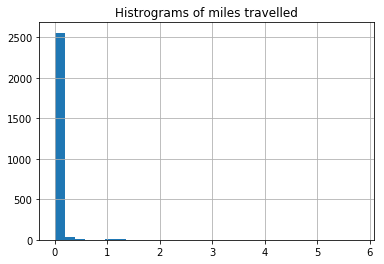

In [10]:
df_one_day_grp[df_one_day_grp['time_diff_hrs'] > 2]['distance_miles'].hist(bins=30)
plt.title('Histrograms of miles travelled')
plt.show()

### Cluster Scooters that are Stationary

In [23]:
# Define stationary
cond_stationary_1 = (df_one_day_grp['time_diff_hrs'] > 4)
cond_stationary_2 = (df_one_day_grp['distance_miles'] < 0.50)

cond_1_df = df_one_day_grp[cond_stationary_1]
stationary_df = df_one_day_grp[cond_stationary_1 & cond_stationary_2]
non_stationary_df = df_one_day_grp[~cond_stationary_2]

print('Percent of data that meet cond_1: {:.1f}%'.format(len(cond_1_df)/len(df_one_day_grp) * 100))
print('Percent of data that is stationary, given cond_1: {:.1f}%'.format(len(stationary_df)/len(cond_1_df) * 100))
print('Count of non-stationary scooters:', len(non_stationary_df))

Percent of data that meet cond_1: 28.7%
Percent of data that is stationary, given cond_1: 98.3%
Count of non-stationary scooters: 61


In [12]:

def generate_map(df, lat_col, long_col, m=None, color='crimson', center_loc=[38.95026, -77.09355]):
    if not m:
        m = folium.Map(location=center_loc)

    for i in range(0, len(df)-1):
        folium.Circle(
        location=[df[lat_col].iloc[i], df[long_col].iloc[i]],
        radius=5,
        color=color,
        fill=False,
        ).add_to(m)
    return m

In [ ]:
print('Mapping stationary scooters')
m_stationary = generate_map(stationary_df, 'latitude_first', 'longitude_first')
m_stationary

In [14]:
print('Mapping non-stationary scooters, first lat/long')
m_non_stationary_first = generate_map(non_stationary_df, 'latitude_first', 'longitude_first')
m_non_stationary_last = generate_map(non_stationary_df, 'latitude_last', 'longitude_last',
                                     m=m_non_stationary_first, color='blue')

Mapping non-stationary scooters, first lat/long


In [15]:
m_non_stationary_last

In [16]:
non_stationary_df.head()

,id,id_size,latitude_first,latitude_last,longitude_first,longitude_last,date_time_min,date_time_max,time_diff_hrs,distance_miles
25,0102925b-2bdf-4ea1-8a77-a1ecdf19e47e,59,38.892853,38.896721,-77.012115,-77.006271,2019-09-08 15:14:14,2019-09-08 20:29:45,5.258611,0.412443
70,03544076-4157-404c-8837-fbbd4abd48eb,56,38.814426,38.816875,-77.039330,-77.039711,2019-09-08 18:57:00,2019-09-08 23:56:15,4.987500,0.170325
129,05c0ac00-9887-484c-bc8d-6804d0da2ea0,77,38.898277,38.891449,-77.088043,-77.084862,2019-09-08 04:02:31,2019-09-08 11:58:16,7.929167,0.501464
183,085007f6-fa67-4a09-b970-ff33d87c7040,69,38.859726,38.891659,-77.067513,-77.085365,2019-09-08 04:02:33,2019-09-08 23:45:17,19.712222,2.404679
205,0958738f-d89d-42d7-88d9-03ce655e2ee4,50,38.880337,38.886337,-77.106148,-77.096474,2019-09-08 12:36:18,2019-09-08 17:02:51,4.442500,0.665046


In [17]:
def generate_map_trip(df, lat_col_start, long_col_start, lat_col_end, long_col_end,
                     m=None, color='blue', center_loc=[38.95026, -77.09355]):
    if not m:
        print('creating a new map...')
        m = folium.Map(location=center_loc)

    for i in range(0, len(df)-1):
        # Add start and end point
        trip_start_end_point = [(df[lat_col_start].iloc[i], df[long_col_start].iloc[i]),
                          (df[lat_col_end].iloc[i], df[long_col_end].iloc[i])]
        folium.PolyLine(locations=trip_start_end_point, color=color, opacity=0.3).add_to(m)
        # Draw arrows 
        arrows = get_arrows(locations=trip_start_end_point, n_arrows=3)
        for arrow in arrows:
            arrow.add_to(m)
    return m

In [24]:
m_move = generate_map_trip(non_stationary_df, 'latitude_first', 'longitude_first',
                           'latitude_last', 'longitude_last')

creating a new map...


In [25]:
m_move